# 제주시 버스 승하차 데이터를 활용한 유동인구 분석

## 제주시 교통의 현주소
제주도내 주민등록인구는 2022년 기준 약 68만명으로, 연평균 1.3%정도 매년 증가하고 있습니다.

또한 외국인과 관광객까지 고려하면 전체 상주인구는 90만명을 넘을 것으로 추정되며, 

제주도민 증가와 외국인의 증가로 현재 제주도의 교통체증이 심각한 문제로 떠오르고 있습니다.
제주도 버스의 효율적인 운행을 위해선 어떤 방법이 고안되어야할지 분석을 통해 알아봅시다.



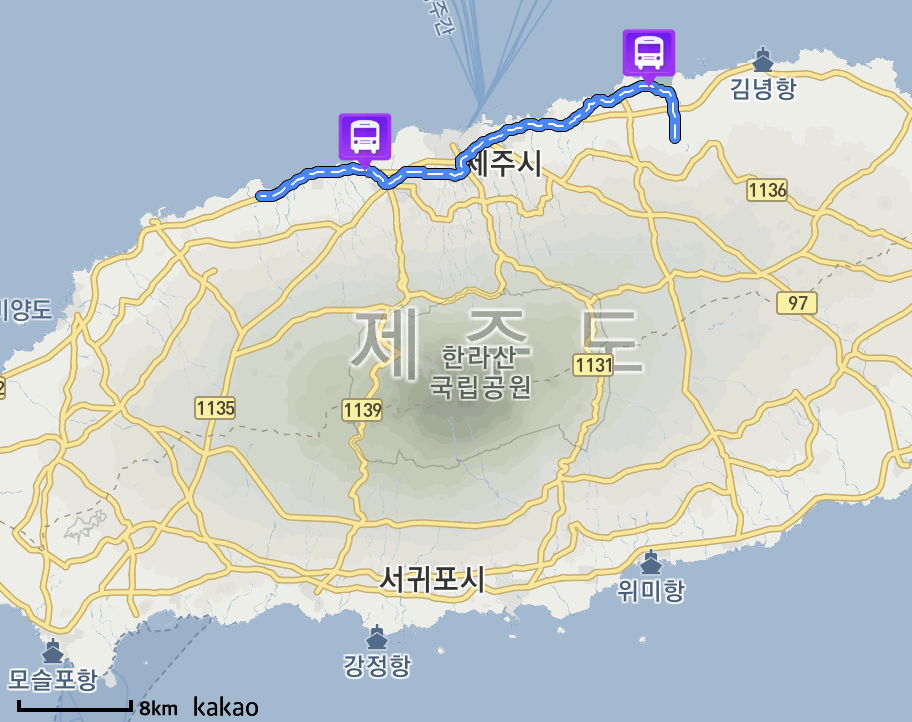

# 분석을 위한 기본 Setting

In [1]:
#@title Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re

import warnings #경고 미출력
warnings.filterwarnings('ignore')


# 지도 관련 시각화 
import folium 
from folium.plugins import MarkerCluster 
import geopy.distance 

#processing bar
from tqdm.notebook import tqdm

from pandas import DataFrame as dff
from pprint import pprint

In [3]:
#@title 필요한 옵션 세팅

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 50)

pd.reset_option('display.float_format')


# 데이터 파악

## 데이터 설명
- 제주 퇴근시간 버스승차인원 예측 경진대회 
  - 버스카드를 통해 결제를 한 경우에 대한 정류소 승/하차 데이터 
    - 기간 : 2019년 9월 1일 ~ 2019년 10월 16일
  - 버스에서 하차를 할 때, 버스카드를 찍지 않는 경우 해당 기록이 nan 처리
    - 승차 인원수와 하차 인원수가 동일하지 않고 다소 차이 발생 (승차인원 >= 하차인원)
    - 같은 정류장의 이름이라도 위도와 경도가 서로 다른 경우, 길 건너편의 정류장

## 테이블 정의서

* bus data (raw data : 241만 데이터)
  - user_card_id : 거래카드 ID
  - bus_route_id : 노선 ID
  - vhc_id : 차량 ID
  - geton_date : 승차시점 날짜
  - geton_time : 승차시점 시각
  - geton_station_code : 승차 정류소 코드
  - geton_station_name : 승차 정류소 이름
  - getoff_date : 하차시점 날짜
  - getoff_time : 하차시점 시각
  - getoff_station_code : 하차 정류소 코드
  - getoff_station_name : 하차 정류소 이름
  - user_category : 사용자 카테코리
  - user_count : 승차 인원

* agg data (bus data의 집계본... bus data를 가공한 결과)
  - id : 해당 데이터의 고유 ID
  - date : 날짜
  - bus_route_id : 노선 ID
  - in_out : 시내버스, 시외버스 구분
  - station_code : 해당 승하차 정류소의 ID
  - station name : 해당 승하차 정류소의 이름
  - latitude : 해당 버스 정류장의 위도
  - longitude : 해당 버스 정류장의 경도

In [4]:
#@title 데이터 로드 (제주 버스 승하차 정보 / 집계 데이터)
bus = pd.read_csv('/content/drive/My Drive/data/bus_bts.csv', index_col = 0)
bus = bus.reset_index()

train = pd.read_csv('/content/drive/My Drive/data/train.csv', index_col = 0)
test = pd.read_csv('/content/drive/My Drive/data/test.csv', index_col = 0)

In [5]:
#@title Agg 데이터 생성 
# train + test = agg data

agg = pd.concat([train,test], axis = 0)
agg.shape

(643593, 20)

## 기본적인 전처리

In [6]:
#@title 날짜형식 변환 : pd.to_datetime
# pd.to_datetime() : 날짜형식의 의미를 갖는 칼럼을 날짜형식으로 바꿔주는 func

bus['geton_date'] = pd.to_datetime(bus['geton_date'])
bus['getoff_date'] = pd.to_datetime(bus['getoff_date'])

agg['date'] = pd.to_datetime(agg['date'])

In [7]:
# @title loc & query 차이
# 1. loc : df.loc[df.변수 관련 조건식]
# 2. query : df.query(변수 관련 조건식)
# bus.loc[bus.geton_date < '2019-10-01']
bus.query('geton_date < "2019-10-01"')

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548754,1.041011e+15,27150000,149796042,2019-09-29,11:52:31,1222,만장굴입구,2019-09-29,11:54:14,1537.0,김녕미로공원,1,1
1548755,9.445421e+15,27150000,149796042,2019-09-30,09:58:11,1016,하덕천,2019-09-30,10:25:02,863.0,세화환승정류장(세화리),1,1
1548756,9.035162e+15,27250000,149796628,2019-09-28,09:36:39,2714,문화마을,NaT,NaN,NaN,NaN,6,1
1548757,1.040010e+15,27250000,149796628,2019-09-30,09:50:05,2714,문화마을,NaT,NaN,NaN,NaN,1,1


## 데이터 구조

### bus data

In [8]:
#@title 1. 1개의 노선에 여러 대의 버스 운행

print(bus.shape)
print(bus.info())
print()
bus.groupby(['bus_route_id','vhc_id']).head().head(2)


(2409414, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409414 entries, 0 to 2409413
Data columns (total 13 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_card_id         float64       
 1   bus_route_id         int64         
 2   vhc_id               int64         
 3   geton_date           datetime64[ns]
 4   geton_time           object        
 5   geton_station_code   int64         
 6   geton_station_name   object        
 7   getoff_date          datetime64[ns]
 8   getoff_time          object        
 9   getoff_station_code  float64       
 10  getoff_station_name  object        
 11  user_category        int64         
 12  user_count           int64         
dtypes: datetime64[ns](2), float64(2), int64(5), object(4)
memory usage: 239.0+ MB
None



,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1


In [9]:
#@title 2. 결제카드 ID 1개(1 사람) 당 여러 결제내역이 존재

pd.options.display.float_format = '{:.0f}'.format
one = bus.user_card_id[0]
bus.query("user_card_id == @one").head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1010010127894129,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592,화북초등학교,1,1
13943,1010010127894129,23000000,149793673,2019-09-11,06:32:23,360,노형오거리,2019-09-11,07:12:57,592,화북초등학교,1,1
76359,1010010127894129,23000000,149793684,2019-09-16,06:32:19,360,노형오거리,2019-09-16,07:15:08,592,화북초등학교,1,1
139006,1010010127894129,23000000,149793651,2019-09-18,06:32:25,360,노형오거리,2019-09-18,07:10:45,592,화북초등학교,1,1
188510,1010010127894129,23000000,149793693,2019-09-27,06:32:26,360,노형오거리,2019-09-27,07:13:34,592,화북초등학교,1,1


### agg data

In [10]:
# @title 데이터 파악

print(agg.info())
print()
agg.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643593 entries, 0 to 643592
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           643593 non-null  datetime64[ns]
 1   bus_route_id   643593 non-null  int64         
 2   in_out         643593 non-null  object        
 3   station_code   643593 non-null  int64         
 4   station_name   643593 non-null  object        
 5   latitude       643593 non-null  float64       
 6   longitude      643593 non-null  float64       
 7   6~7_ride       643593 non-null  float64       
 8   7~8_ride       643593 non-null  float64       
 9   8~9_ride       643593 non-null  float64       
 10  9~10_ride      643593 non-null  float64       
 11  10~11_ride     643593 non-null  float64       
 12  11~12_ride     643593 non-null  float64       
 13  6~7_takeoff    643593 non-null  float64       
 14  7~8_takeoff    643593 non-null  float64       
 15  

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
id,,,,,,,,,,,,,,,,,,,,
0,2019-09-01,4270000,시외,344,제주썬호텔,33,126,0,1,2,5,2,6,0,0,0,0,0,0,0
1,2019-09-01,4270000,시외,357,한라병원,33,126,1,4,4,2,5,6,0,0,0,0,0,0,5
2,2019-09-01,4270000,시외,432,정존마을,33,126,1,1,0,2,0,0,0,0,0,0,0,0,2
3,2019-09-01,4270000,시내,1579,제주국제공항(600번),34,126,0,17,6,26,14,16,0,0,0,0,0,0,53
4,2019-09-01,4270000,시내,1646,중문관광단지입구,33,126,0,0,0,0,0,0,0,0,0,1,0,0,0


In [11]:
# @title bus 데이터와의 공통 칼럼 존재 : bus_route_id
[i for i in agg.columns if i in bus.columns]

['bus_route_id']

### 스키마 파악
- bus 데이터와 agg 데이터의 관계
  - station_name(left_on) & geton_station_name(right_on)으로 merge
  - station_name(left_on) & getoff_station_name(right_on)으로 merge
    - bus 데이터에 위도와 경도 붙일 수 있음

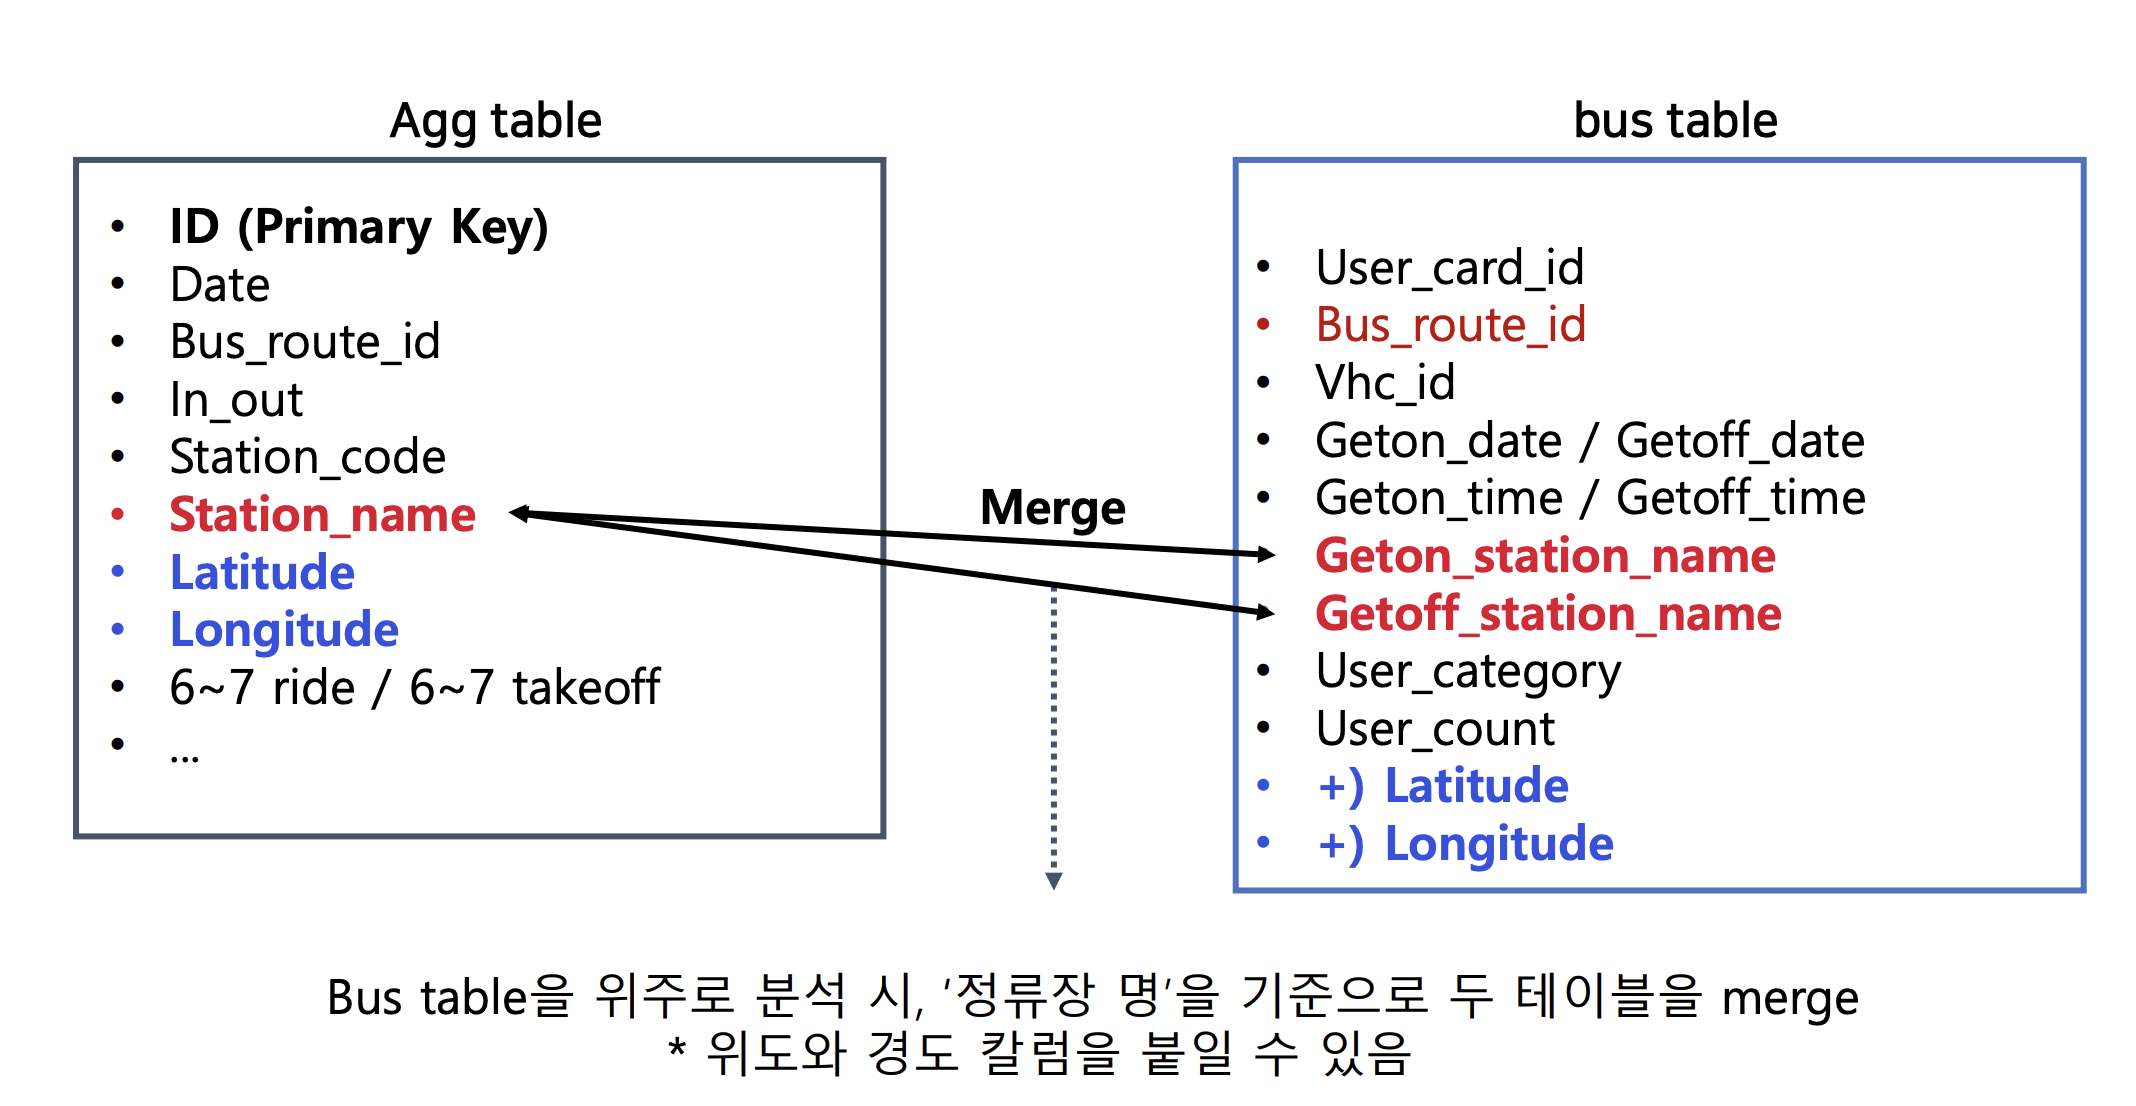

In [12]:
# @title bus data와 agg data 비교 : [agg data = bus data의 집계본]
tmp1 = bus[(bus.geton_station_name  == '제주썬호텔') & (bus.bus_route_id == 4270000) & (bus.geton_date == '2019-09-01')].sort_values(by = 'geton_time')
tmp2 = agg[(agg.bus_route_id == 4270000) & (agg.date == '2019-09-01') & (agg.station_name  == '제주썬호텔')]
display(tmp2, tmp1)

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
id,,,,,,,,,,,,,,,,,,,,
0,2019-09-01,4270000,시외,344,제주썬호텔,33,126,0,1,2,5,2,6,0,0,0,0,0,0,0


,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
910225,4330288829561111,4270000,149793716,2019-09-01,07:48:24,344,제주썬호텔,NaT,NaN,NaN,NaN,1,1
412486,4619541003088125,4270000,149793717,2019-09-01,08:05:54,344,제주썬호텔,2019-09-01,08:51:16,2095,켄싱턴제주호텔입구,1,1
426043,6060456088703945,4270000,149793717,2019-09-01,08:05:58,344,제주썬호텔,NaT,NaN,NaN,NaN,1,1
903391,4579720617777046,4270000,149793705,2019-09-01,09:08:38,344,제주썬호텔,2019-09-01,09:51:21,1646,중문관광단지입구,1,1
910427,6258040301382000,4270000,149793708,2019-09-01,09:28:37,344,제주썬호텔,NaT,NaN,NaN,NaN,2,1
892832,1019150179794615,4270000,149793708,2019-09-01,09:28:47,344,제주썬호텔,2019-09-01,10:12:53,2843,중문관광단지여미지식물원입구,1,1
912556,1040009701544334,4270000,149793707,2019-09-01,09:49:03,344,제주썬호텔,NaT,NaN,NaN,NaN,1,1
897587,1010010120230354,4270000,149793707,2019-09-01,09:49:06,344,제주썬호텔,NaT,NaN,NaN,NaN,1,1
911980,5155944992355348,4270000,149793711,2019-09-01,10:16:37,344,제주썬호텔,NaT,NaN,NaN,NaN,1,1
911981,4854790267659808,4270000,149793711,2019-09-01,10:16:52,344,제주썬호텔,NaT,NaN,NaN,NaN,1,1


# 분석 방향성 가이드 (1번 / 2번 / 3번)
1. **user_card_id 기준** : 사용자의 이동경로 분석 (고정경로, 유동경로) .. 차이?
  - user_category에 따라 다를까?
  - 노선에 따라 다를까?
  
2. **bus_route_id 기준** : 시간에 따른 해당 노선의 user 파악  

3. **user_count 기준** : 
  - 탑승 수가 많은 루트기준, 9월 한달 동안의 이동경로 시각화 <-> 10월 한달 동안의 이동경로와 비교
  - 탑승 수가 적은 루트기준, 9월 한달 동안의 이동경로 시각화 <-> 10월 한달 동안의 이동경로와 비교


# 추가 Tip (각자 프로젝트에 녹여볼 부분)
1. 다른 데이터를 추가로 고려
  - 날씨 데이터
  - 공휴일 여부
  - 특정사건 여부(인사이트 뽑을 때, 설명을 부여)
2. 가설 세우기 -> 검증
  - 공휴일/휴일 vs 평일 
    - 평일일 때 사람들이 더 많이 이용할 것 (user_count가 높을 것)
      - A 노선 : 평일 > 주말/공휴일
      - B 노선 : 평일 < 주말/공휴일 ... why?
3. 프로젝트 취지. 
  - 1. 데이터 가지고 놀기 :Data Handling & Visualization skill 
  - 2. 분석 Flow 익히기
  - 3. 인사이트 발굴해보기 


In [13]:
#@title 1번 : 사용자(user_card_id) 기준
# _약 33만명의 사용자

nnumber = bus.user_card_id.nunique()
number_of_ppl = 326776 #@param 

In [14]:
# 경로 변수 생성 (출발지 & 도착지 조합)
bus['geton_getoff'] = bus.geton_station_name + '_' + bus.getoff_station_name
bus = bus.dropna(axis = 0) # 결측치 제거

In [15]:
# user_card_id : 숫자의 의미가 아닌, 명목형 변수
bus['user_card_id'] = bus['user_card_id'].astype(int)
bus['user_card_id'] = bus['user_card_id'].astype(str)

In [16]:
# 9월 & 0월 데이터
print(bus.shape)
sep = bus.query("geton_date < '2019-10-01'").sort_values(by = 'geton_date')
oct = bus.query("geton_date >= '2019-10-01'").sort_values(by = 'geton_date')


(1513612, 14)


In [ ]:
# 경로가 고정적인 사용자들 : max값이 0.8 초과
id_list = []
for id in tqdm(bus.user_card_id):
  subset = bus.query("user_card_id == @id")
  subset_size = subset.groupby(['geton_getoff']).size()
  max_ratio = subset_size.apply(lambda x : x / subset_size.sum()).max()

  if max_ratio > 0.9:
    id_list.append(id)

  0%|          | 0/1513612 [00:00<?, ?it/s]

In [ ]:
#@title 1-1. 경로가 고정적인 사용자는 전체의 약 %, 그 중 카테고리  사용자들이 % 이상
fix_user = bus[bus.user_card_id.isin(id_list)]
fix_user_ratio = (fix_user.shape[0] / bus.shape[0]) * 100
print(fix_user_ratio)

In [ ]:
# 경로가 고정적인 사용자들이 다니는 경로의 갯수
fix_user = bus[bus.user_card_id.isin(id_list)]
a = dff(fix_user.groupby(['user_card_id','geton_getoff']).agg('size'))
a.columns = ['size']
a.reset_index().sort_values(by = ['size'])

In [ ]:
bus.query("user_card_id == @id_list").groupby(['geton_getoff']).size().sort_values(ascending = False).head(10)


In [ ]:
# 사용자 카테고리별 고정경로 사용자들의 분포
dff(fix_user.groupby(['user_category']).size()).sort_values(ascending = False)

In [ ]:
# 경로가 유동적인 사용자들 : 모든 경로의 비율이 0.1 이하 (즉, max 값이 0.1이하)
id_list_2 = []
for id in tqdm(bus.user_card_id):
  subset = bus.query("user_card_id == @id")
  subset_size = subset.groupby(['geton_getoff']).size()
  max_ratio = subset_size.apply(lambda x : x / subset_size.sum()).max() # 모든 경로의 비율 중 max 값

  if max_ratio <= 0.1:
    id_list_2.append(id)


In [ ]:
#@title 1-2. 경로가 유동적인 사용자는 전체의 약 %, 그 중 카테고리  사용자들이 % 이상
change_user = bus[bus.user_card_id.isin(id_list2)]
change_user_ratio = (change_user.shape[0] / bus.shape[0]) * 100
print(change_user_ratio)


In [ ]:
#@title 2번 : 버스 노선(bus_route_id) 기준
# two -> sep / oct
two = bus[['bus_route_id','geton_date','geton_time','getoff_date','getoff_time','geton_station_name','getoff_station_name','user_category','user_count','user_card_id']]
sep = two[two.geton_date < '2019-10-01'].sort_values(by = 'geton_date')
oct = two[two.geton_date >= '2019-10-01'].sort_values(by = 'geton_date')

In [ ]:
#@title 2-1. 버스 노선별 총 탑승자 수 통계 : 사람들이 가장 많이 탑승하는 노선 
sep_best_5 = ['23610000', '23620000', '22530000', '23580000', '225200000'] #@param
oct_best_5 = ['23610000', '23620000', '22530000', '23570000', '225200000'] #@param

# 해당 버스 노선들이 교통 체증의 원인이 될 가능성이 농후

route_rank5_sep = dff(sep.groupby(['bus_route_id']).sum()['user_count'].sort_values(ascending = False)).reset_index().bus_route_id[:5].values
route_rank5_oct = dff(oct.groupby(['bus_route_id']).sum()['user_count'].sort_values(ascending = False)).reset_index().bus_route_id[:5].values



In [ ]:
#@title 2-2-1. 버스 노선별/경로별 총 탑승자 수 통계 : 9월/10월 사람들이 가장 많이 이용하는 버스 노선에서는 어떤 경로로 사람들이 가장 많이 탑승할까?
# 예시1 : 23610000 노선
# 출발 : 제주시청(광양방면) | 제주지방법원(광양방면) -> 도착 : 중앙로(현대약국) | 제주국제공항(신제주방면)
two[(two.bus_route_id == 23610000)].groupby(['geton_station_name','getoff_station_name']).sum()[['user_count']].sort_values(by = 'user_count', ascending = False).head(20)

In [ ]:
#@title 2-2-2. 버스노선별/경로별 총 탑승자 수 시각화(히트맵)
tmp = two.groupby(['bus_route_id','geton_dategeton_getoff']).sum()[['user_count']]
route_best_5 = [23610000, 23620000, 22530000, 23580000,23570000,225200000]

tmp_most = tmp.reset_index().query("bus_route_id in @route_best_5")

In [ ]:
#@title 2-2-2. 데이트프레임 재구조화 (Reshape)

# 범주형 변수 : bus_route_id, geton_getoff, 
# 수치형 변수 : user_count

# row : 버스노선 id 
# column : 루트(출발 & 도착)  
# value : user_count (row & column에 매칭되는 값)

In [ ]:
# 범주형 변수 2개
# 1개 : bus_route_id, 1개 : geton_getoff (다 : 다) .. 다대다 조합
# 범주형 변수의 조합의 count ... pd.crosstab(변수1, 변수2)

# ----------------------------pd.crossbtab 설명------------------------------------------------------
# 범주형 변수1 : '이름'
# 범주형 변수2 : '수능 등급'

# 1) original data
# 이름 : 철수,영희,짱구
# 수능 등급 : 철수 : (1,1,1)
#             영희 : (1,2,1)
#             짱구 : (3,2,4)

# 2) crosstab data
# pd.crosstab([철수,영희,짱구] * [1,2,3,4]) = 3 by 4 matrix
# index = 철수,영희,짱구
# column = 1,2,3,4

# 결과) 원래 데이터프레임 상 :짱구같은 경우는 수능 등급, 1등급을 맞아본 적이 없기 때문에 짱구와 1등급의 조합은 존재하지 않는다. 
#      crosstab 데이터프레임 상 :짱구같은 경우는 수능 등급, 1등급에 들어가는 값이 0으로 나오게끔 함수가 구성되어 있음

# 사용 방법
# pd.crosstab(변수1, 변수2)

In [ ]:
route_on_off = pd.crosstab(tmp_most['bus_route_id'],  tmp_most['geton_getoff'])


# try~except 
# 예외 처리 구문
# 반복문 특성상, 반복문이 돌아가다가 중간에 에러발생하면 -> 바로 멈추죠

# idx, column : route_on_off 기준
for idx in tqdm(route_on_off.index): # column이 6개니까
  # print(idx)
  for column in route_on_off.columns: # tqdm()
    # print(column)
    try:
      route_on_off.loc[idx, column] = tmp_most.loc[(tmp_most.bus_route_id == idx) & (tmp_most.geton_getoff == column)].user_count.values[0]
    except:
      route_on_off.loc[idx, column] = 0

In [ ]:
# normalize

# range - normalize
for idx in tqdm(route_on_off.index):
  for column in route_on_off.columns:
    route_on_off.loc[idx, column] = route_on_off.loc[idx, column] / m[idx]

In [ ]:
# 시각화
# 동문로터리/비석거리/신천단한국폴리텍대학/서귀포 시외버스터미널 출발 .. <- 출발지 사람들이 많이 탑승한다
import plotly.express as px

fig = px.imshow(route_on_off)
fig.show()

In [ ]:
#@title 버스 노선별/일자별
#@title 버스 노선별/시간별

In [ ]:
# 시각 -> 시간으로 전처리
two['geton_hour'] = two['geton_time'].apply(lambda x: x[:2])
two['getoff_hour'] = two['getoff_time'].apply(lambda x: x[:2] if type(x) == str else x)

# two['getoff_hour'] = two['getoff_time'].apply(lambda x: x[:2] if x != np.nan)

In [ ]:
#@title 2-3. 버스 노선별/시간별 통계 : 평균적으로 사람들이 많이 탑승하는 시간대, 적게 탑승하는 시간대
pd.DataFrame(two.groupby(['geton_hour','getoff_hour']).meah()['user_count']).sort_values(by = 'user_count', ascending = False)

In [ ]:
two[two.bus_route_id == 23610000].groupby(['geton_hour','getoff_hour']).sum()[['user_count']]

## 3번 방향
- 이동 루트 시각화 (네트워크 분석)
- 원소 A와 원소 B, 원소 C
  - A와 B 관계?
  - A와 C 관계?
  - B와 C 관계?
- 네트워크 분석 : 노드 + 엣지 구성
  - 노드 :원소 (A,B,C)
  - 엣지 : 관계


In [ ]:
#@title 3번

In [ ]:
bus

In [ ]:
bus.info()

## 전처리

In [ ]:
# query .. 직관적, 
date_ls = ['2019-09-10','2019-10-10']
# bus.query("(geton_date == '2019-09-10') | (geton_date == '2019-10-10')")
bus.query("geton_date in @date_ls")

In [ ]:
# 9월,10월 데이터
sep = bus.query("geton_date < '2019-10-01'").sort_values(by = 'geton_date')
oct = bus.query("geton_date >= '2019-10-01'").sort_values(by = 'geton_date')


In [ ]:
(pd.DataFrame(sep.isnull().sum()).loc['getoff_date', :].values[0] / sep.shape[0]) * 100

In [ ]:
print(sep.shape[0])
print(sep.isnull().sum())
print((pd.DataFrame(sep.isnull().sum()).loc['getoff_date', :].values[0] / sep.shape[0]) * 100)
print()
print(oct.shape[0])
print(oct.isnull().sum())
print((pd.DataFrame(oct.isnull().sum()).loc['getoff_date', :].values[0] / oct.shape[0]) * 100)

In [ ]:
# @title 결측치 행 제거
sep_clean = sep.dropna(axis = 0)
oct_clean = oct.dropna(axis = 0)

# sep_clean['route'] = sep_clean['geton_station_name'] + '_' + sep_clean['getoff_station_name']
# oct_clean['route'] = oct_clean['geton_station_name'] + '_' + oct_clean['getoff_station_name']


In [ ]:
sep_clean.shape[0], oct_clean.shape[0]

In [ ]:
pd.options.display.float_format = '{:.1f}'.format

In [ ]:
sep_clean.head()

In [ ]:
# 복수의 리스트 _ 데이터프레임 (subset)
# df[복수 칼럼 리스트]
# df[['a','b','c']]

In [ ]:
# 열 정렬
new_cols = ['user_card_id', 'bus_route_id','vhc_id','geton_date','geton_time','getoff_date','getoff_time','geton_station_name','getoff_station_name','user_category','user_count']
sep_clean = sep_clean[new_cols].reset_index(drop = True)
oct_clean = oct_clean[new_cols].reset_index(drop = True)

In [ ]:
# node 구성
# 인덱스, 출발지명, 출발지명 관련 명목 변수, cnt_sum


In [ ]:
# @title 9월 출발지 기준 sum
# groupby .. 통계치 / 집계자료
sep_clean_start = pd.DataFrame(sep_clean.groupby(['geton_station_name']).sum()['user_count']).reset_index()
sep_clean_start.sort_values(by = 'user_count', ascending = False).head(10)

# question : why '한라병원' is the largest count? .. 추가 분석

In [ ]:
# @title 10월 출발지 기준 sum
# groupby .. 통계치 / 집계자료
oct_clean_start = pd.DataFrame(oct_clean.groupby(['geton_station_name']).sum()['user_count']).reset_index()
oct_clean_start.sort_values(by = 'user_count', ascending = False).head(10)

In [ ]:
# @title 9월 도착지 기준 sum
# 왜 도착지에도 한라병원이 가장 많을까?

sep_clean_end = pd.DataFrame(sep_clean.groupby(['getoff_station_name']).sum()['user_count']).reset_index()
sep_clean_end.sort_values(by = 'user_count', ascending = False).head(10)

In [ ]:
# @title 10월 도착지 기준 sum

oct_clean_end = pd.DataFrame(oct_clean.groupby(['getoff_station_name']).sum()['user_count']).reset_index()
oct_clean_end.sort_values(by = 'user_count', ascending = False).head(10)

In [ ]:
# @title 9월 출발-도착 pair 기준 sum
# A 장소 -> B 장소 (A = B) ... 의미 있는 분석을 할 수 없겠다고 판단 -> 제거
sep_clean_s_e = pd.DataFrame(sep_clean.groupby(['geton_station_name','getoff_station_name']).sum()['user_count']).reset_index()
sep_clean_s_e.sort_values(by = 'user_count', ascending = False).head(10)

In [ ]:
sep_clean_s_e.query("getoff_station_name == '제주국제공항(구제주방면)'").sort_values(by = 'user_count', ascending = False).head(10)

In [ ]:
sep_clean_s_e.query("geton_station_name == '제주도청신제주로터리'").sort_values(by = 'user_count', ascending = False).head(10)

In [ ]:
sep_clean.query("geton_station_name == '제주도청신제주로터리'").sort_values(by = 'user_count', ascending = False)

In [ ]:
# @title 10월 출발-도착 pair 기준 sum
# 여러분들이 직접 해보세요.!

In [ ]:
# @title Node without self : sep_without / oct_without
# 출발지 = 도착지 제외 코드

In [ ]:
# 자기제외 데이터프레임 logic
sep_exclude_row = []
for idx, row in sep_clean.iterrows():
  if row.geton_station_name == row.getoff_station_name:
    sep_exclude_row.append(idx)

oct_exclude_row = []
for idx, row in oct_clean.iterrows():
  if row.geton_station_name == row.getoff_station_name:
    oct_exclude_row.append(idx)

sep_include_row = [i for i in sep_clean.index if i not in sep_exclude_row] # 9월 제외리스트에 없는 애들 -> 포함시킬 인덱스
oct_include_row = [i for i in oct_clean.index if i not in oct_exclude_row] # 10월 제외리스트에 없는 애들 -> 포함시킬 인덱스

# 자기제외 전체 데이터프레임 결과 (시작/도착 지점 같은 행 제외)
sep_without = sep_clean.iloc[sep_include_row,:]
oct_without = oct_clean.iloc[oct_include_row,:]

In [ ]:
print(sep_clean.shape, sep_without.shape)
print(sep_clean.shape[0] - sep_without.shape[0])
print(oct_clean.shape, oct_without.shape)
print(oct_clean.shape[0] - oct_without.shape[0])

In [ ]:
print(len(sep_clean.geton_station_name.unique()))
print(len(oct_clean.geton_station_name.unique()))

# 네트워크 분석
- 각 노드들이 어떤 노드들로 이어지는지에 대한 분석
- 구성 : node & edge
  - node : element
  - edge : element & element 연결하는 선
- 노드 구성 : 출발지 기준
- 엣지 구성 : 출발지 -> 도착지 pair

In [ ]:
sep_start = sep_without.geton_station_name.unique() # 출발지명
len(sep_start)

sep_end = sep_without.getoff_station_name.unique() # 도착지명
len(sep_end)

In [ ]:
# 9월 데이터 (자기제외 df)
sep_start = sep_without.geton_station_name.unique() # 유니크한 출발지명
sep_end = sep_without.getoff_station_name.unique()  # 유니크한 도착지명

print(len([i for i in sep_start if i not in sep_end])) # start에는 있는데, end에는 없는 경우
print(len([i for i in sep_end if i not in sep_start])) # end에는 있는데, start에는 없는 경우
 
oct_start = oct_without.geton_station_name.unique()
oct_end = oct_without.getoff_station_name.unique()

In [ ]:
print(len([i for i in sep_start if i in sep_end]), len([i for i in sep_end if i in sep_start]))

In [ ]:
[i for i in sep_start if i not in sep_end]

In [ ]:
len([i for i in sep_end if i not in sep_start])

In [ ]:
# 공통 정류장
sep_com = [i for i in sep_start if i in sep_end]
oct_com = [i for i in oct_start if i in oct_end]



In [ ]:
sep_without.shape

In [ ]:
sep_without.geton_station_name[0] # 행 넣고 , 행 제외

In [ ]:
sep_without.geton_station_name.isin(sep_com)

In [ ]:
# # loc
# sep_without.loc[sep_without.geton_station_name.isin(sep_com)]

In [ ]:
# 자기제외 데이터프레임 & 공통 정류장 있는 df
sep_without = sep_without.query("geton_station_name in @sep_com") # sep_without[sep_without.geton_statiaon_name.isin(sep_com)]
oct_without = oct_without.query("geton_station_name in @oct_com") # sep_without[sep_without.geton_statiaon_name.isin(sep_com)]

In [ ]:
# sep_without.head()

In [ ]:
# @title 9월 데이터프레임 (네트워크 분석에 필요한) 구성


In [ ]:
# @title 9월 노드 구성 : sep_node_without
# 노드 : 출발지 기준 (변수명 : geton_station_name) + 구분자 : user_category + index (edge 연결을 하기 위한 구분자)
# 엣지 : 출발지 & 도착지 pair dataframe

In [ ]:
# 출발지, 사용자 그룹 별 집계
sep_node_without = pd.DataFrame(sep_without.groupby(['geton_station_name','user_category']).sum()['user_count'])
sep_node_without = sep_node_without.reset_index().reset_index()
sep_node_without.rename(columns = {'user_count':'user_sum'}, inplace = True)
sep_node_without

# index (구분자 코드)
# 0 : 구판장 & user 1
# 2 : 구판장 & user 6

In [ ]:
# @title 10월 데이터프레임 (네트워크 분석에 필요한) 구성 : oct_node_without
oct_node_without = pd.DataFrame(oct_without.groupby(['geton_station_name','user_category']).sum()['user_count'])
oct_node_without = oct_node_without.reset_index().reset_index()
oct_node_without.rename(columns = {'user_count':'user_sum'}, inplace = True)



In [ ]:
display(sep_node_without.head(), oct_node_without.head())

In [ ]:
#  구판장 시작일 때
a = sep_without.groupby(['geton_station_name','getoff_station_name','user_category']).sum()['user_count'].reset_index()
a[a.geton_station_name == '(구)구판장']

In [ ]:
sep_node_without.sort_values(by = 'user_sum', ascending = False)

In [ ]:
#@title 노드 df 구성요소
# index(출발 인덱스), 출발지명, user_category, user_sum

In [ ]:
# # @title Edge (new)
# a = sep_without.groupby(['geton_station_name','getoff_station_name',]).sum()['user_count'].reset_index()
# a = pd.merge(a, sep_node_without, on = ['geton_station_name',])
# a = a.drop(['user_sum'], axis = 1)
# a.rename(columns = {'user_count':'total_count',
#                     'index':'from_index'}, inplace = True)
# a

In [ ]:
# # from index 구성
# pqir_sum_by_category = sep_without.groupby(['geton_station_name','getoff_station_name','user_category']).sum()['user_count'].reset_index()
# display(sep_node_without.head(), pqir_sum_by_category.head())

# pd.merge(sep_node_without, pqir_sum_by_category, on = ['geton_station_name','user_category'])

In [ ]:
# @title 9월 Edge
# pair로 넣기 위해서 getoff_station_name 칼럼을 추가로 groupby의 기준으로 부여
pqir_sum_by_category = sep_without.groupby(['geton_station_name','getoff_station_name','user_category']).sum()['user_count'].reset_index()
tmp1 = pd.merge(pqir_sum_by_category, sep_node_without, on = ['geton_station_name','user_category'])
tmp1 = tmp1.drop(['user_sum'], axis = 1)
tmp1.rename(columns = {'user_count':'total_count',
                    'index':'from_index'}, inplace = True)
tmp1

# from_index만 만들고, to_index를 만들어야하는 상황

# 도착지 명 '관통사' -> 출발지 명 '관통사' (도착치 != 출발지)

In [ ]:
# 엣지를 만들려고
# 엣지 구성요소, geton_station_name, geoff_station_name, user_cateogory, user_sum, index (출발 / 도착)
display(sep_node_without, pqir_sum_by_category)

In [ ]:
sep_node_without.head()

In [ ]:
# tmp1 - tmp2
# tmp1 : 첫번째 merge 결과 <- 활용 
# left : tmp1
# right : sep_node_without의 subset

In [ ]:
#@title from_index & to_index 구성
# left : tmp1 (from_index)
# right : sep_node_without (subset)

# 도착지명이 출발지인 경우 (A != B)
tmp2 = pd.merge(tmp1, sep_node_without[['index','geton_station_name','user_category']], left_on = ['getoff_station_name','user_category'], right_on = ['geton_station_name','user_category'])
tmp2 = tmp2.drop(['geton_station_name_y'], axis = 1)
tmp2.rename(columns = {'index':'to_index',
                    'geton_station_name_x':'geton_station_name'}, inplace = True)
# tmp2.query("geton_station_name == '(구)구판장'")

In [ ]:
tmp2

In [ ]:
tmp2.query("geton_station_name == '(구)구판장'")

In [ ]:
# @title 최종 데이터프레임 구성 : tmp2
# node -> sep_node_without
# edge -> tmp2

In [ ]:
tmp2.sort_values(by = 'total_count', ascending = False)

In [ ]:
tmp2[tmp2.total_count <= 14]

In [ ]:
#@title Total Count 분포 파악
import plotly.express as px

fig = px.histogram(tmp2, x="total_count",
                   marginal="box", # or violin, rug
                   hover_data=tmp2.columns)
fig.show()

In [ ]:
sep_node_without.to_csv('/content/drive/MyDrive/data/sep_node_without.csv')
tmp2.to_csv('/content/drive/MyDrive/data/sep_edge_without.csv')

In [ ]:
tmp2[tmp2.user_category == 4]

In [ ]:
#@title 네트워크 plot
# vizNetwork in R (python과는 비슷하지만, 다른 프로그래밍 언어 (통계))
# r을 실행하는 가이드 & 코드 : 노션에 제공해드릴 것

In [ ]:
import os
os.getcwd()

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


node = pd.read_csv('/content/drive/My Drive/data/sep_node_without.csv', index_col = 0)
edge = pd.read_csv('/content/drive/My Drive/data/sep_edge_without.csv', index_col = 0)


In [ ]:
! pip install scipy

In [ ]:
! pip install networkx==2.6.3

In [ ]:
#@title 파이썬 코드
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load node and edge data
# node = pd.read_csv('sep_node_without.csv', header = True)
node = node[['index', 'geton_station_name', 'user_sum', 'user_category']]

# edge = pd.read_csv('sep_edge_without.csv', header = True)
edge = edge[['from_index', 'to_index', 'total_count']]

# Filter edges with total count >= 14
edge = edge[edge['total_count'] >= 14]

# Normalize width of edges
k = 0.4
edge['width'] = k * (edge['total_count'] - edge['total_count'].min()) / (edge['total_count'].max() - edge['total_count'].min())

# Create graph using NetworkX
G = nx.DiGraph()

for index, row in node.iterrows():
    G.add_node(row['index'], label=row['geton_station_name'], value=row['user_sum'], group=row['user_category'])

for index, row in edge.iterrows():
    G.add_edge(row['from_index'], row['to_index'], width=row['width'])

# Plot graph using Matplotlib
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)

# Show plot
plt.show()


In [ ]:
node = pd.read_csv('/content/drive/My Drive/data/sep_node_without.csv', index_col = 0)
edge = pd.read_csv('/content/drive/My Drive/data/sep_edge_without.csv', index_col = 0)

display(node, edge)

In [ ]:
# ! pip install pyvis

In [ ]:
node

In [ ]:
node.loc[0, 'geton_station_name']

In [ ]:
edge2

In [ ]:
from pyvis.network import Network

# Read the node data
# node = pd.read_csv("sep_node_without.csv")
node = node[["index", "geton_station_name", "user_sum", "user_category"]]

# Read the edge data
# edge = pd.read_csv("sep_edge_without.csv")
edge = edge[["from_index", "to_index", "total_count"]]

# Filter the edges with total count greater than 14
edge2 = edge[edge["total_count"] >= 14]

# Normalize the width of the edges
k = 0.4
# edge2["width"] = k * (edge2["total_count"] - edge2["total_count"].min()) / (edge2["total_count"].max() - edge2["total_count"].min())
edge2.loc[:, "width"] = k * (edge2["total_count"] - edge2["total_count"].min()) / (edge2["total_count"].max() - edge2["total_count"].min())

# Create the network
net = Network(notebook=True, height="800px", width="100%")


# Add nodes to the network
for i in range(len(node)):
    net.add_node(n_id = node.loc[i, "index"], label=node.loc[i, "geton_station_name"], value=node.loc[i, "user_sum"], group=node.loc[i, "user_category"])

# Add edges to the network
for i in range(len(edge2)):
    net.add_edge(edge2.loc[i, "from_index"], edge2.loc[i, "to_index"], width=edge2.loc[i, "width"])

# Style the network
net.toggle_physics(True)
net.toggle_stabilization(True)
net.set_edge_color("lightblue")
net.set_edge_highlight_color("red")
net.set_node_size(1)
net.show("jeju_flow.html")


In [ ]:
nodes

# Folium
- 지도 시각화 라이브러리 !
  - interactive한 지도를 생성하고, 마커를 추가하여 시각화 가능

- 기본적인 코드 :  
  m = folium.Map(location = (위도, 경도), zoom_start = 10,  width = 700, height = 500)

- 마커 추가 : 마커를 추가할 위도 & 경도 좌표 입력 후에 표기할 팝업문구와 툴팁을 지정
  - 팝업 문구 : 마우스 클릭 시 표시되는 문구
  - 툴팁 : 마우스 오버 시 표기되는 문구

# 과제
1. 가이드 3 (네트워크 분석)을 방향으로 잡고 과제하기
- 분석을 하는 과정에서 새로운 인사이트 생기거나, 파보고 싶은 part를 발견하고,
분석을 deep-dive 분석
- 10월 시도해보고, 9월과 비교하는 것
  - 9월과 비교하기 전 추가 분석
    - user_cateogory ... 어떻게 다른지 분석
    - 10월은 또 category에 따라 어떻게 다른지

2. 10월 network plot (수업 : 9월 network plot)
- df ... 전처리, 가공 (9월 df  vs 10월 df)
- 9월과 10월 비교

In [ ]:
# 과제
# r file과 html 파일을 노션에 올려드림
# 이용 방법 : 노션에 메뉴얼로 업로드

# 
# 1. 9월 분석
  # category에 따라 어떤 이동경로가 있는지.. 어떤 인사이트 얻는지
  
# 2. 10월 분석 (r file 이용)
 # 10월 네트워크 플랏 + category에 따라 어떤 이동경로가 있는지 
